### Курсовая работа. Классическое машинное обучение
### Раздел 2.3. Регрессия для SI

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [19]:
# Загрузить данные
df = pd.read_csv('si.csv')
display(df.head())
print(df.shape)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,SI
0,-1.812779,1.202897,0.868409,-0.729005,1.094277,0.225177,-1.586455,1.520873,-2.063487,-0.593331,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,2.629564,-0.07706,28.125
1,-2.159098,2.055029,0.960485,-0.517805,1.272861,0.256636,-1.789985,1.261644,-2.213061,-0.583101,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,2.629564,-0.07706,7.000
2,-2.567062,2.109433,0.966363,-1.461422,1.036377,0.710135,-1.147686,1.103015,-2.400029,-0.557746,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,2.629564,-0.07706,0.720
3,-1.795530,0.524481,0.795104,-0.674338,0.593127,0.865439,-1.397847,1.993992,-2.242976,-0.592739,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,-0.140636,-0.07706,1.300
4,-1.609664,0.568684,0.799880,0.645806,-0.025219,-0.181798,-1.397847,0.149177,-0.735268,-0.593425,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,-0.140636,-0.07706,2.000


(847, 146)


In [20]:
SEED = 42

In [21]:
# Разделить данные на признаки и целевую переменную
X = df.drop('SI', axis=1)
y = df['SI']

# Разделить данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (592, 145), (592,)
Train dataset size: (255, 145), (255,)


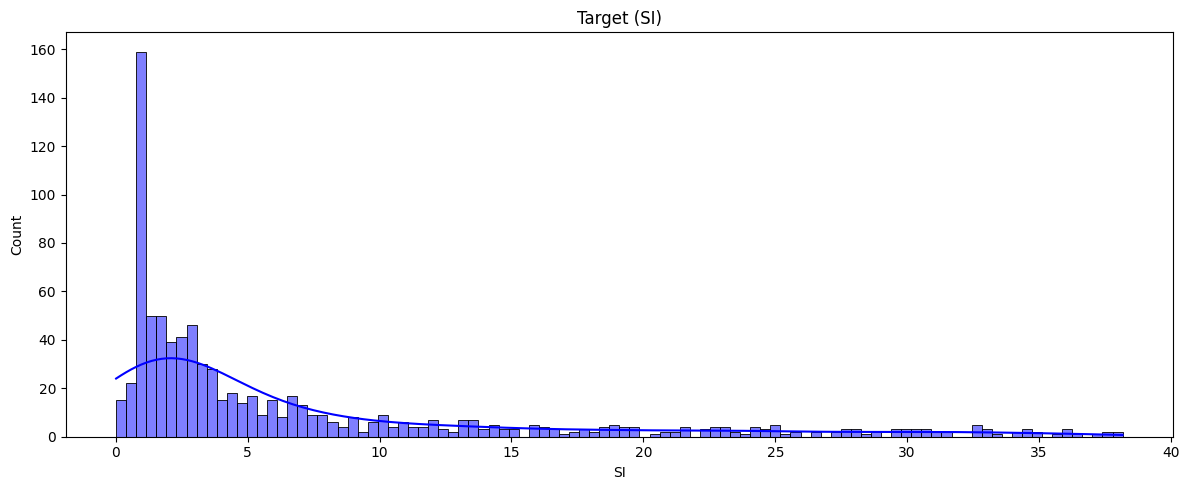

In [22]:
plt.figure(figsize=(12, 5))
sns.histplot(y, kde=True, bins=100, color='blue')
plt.title('Target (SI)')
plt.tight_layout()
plt.show()

В рамках настоящей задачи будем использовать следующие модели:
- Линейные модели (`Lasso`, `Ridge`, `ElasticNet`);
- `RandomForest`;
- `SVR`;
- `XGBoostRegressor`;
- `CatBoostRegressor`.
  
Для анализа эффективности моделей проверим следующие метрики:
- $MAE$;
- $MAPE$;
- $MSE$;
- $R^2$.

Для подбора наиболее оптимальных гиперпараметров воспользуемся поиском по сетке (`GridSearch`).

In [23]:
metrics = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'MSE': 'neg_mean_squared_error'
}
results = {}

**1. Lasso**

In [24]:
params_lr = {'alpha': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 20, 50, 100]}

# Найти приемлимый alpha с помощью GridSearchCV
grid_lasso = GridSearchCV(Lasso(max_iter=10000),
                           param_grid=params_lr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_lasso = grid_lasso.fit(X_train, y_train).best_params_
for param_name, param_values in params_lr.items():
    param = best_params_lasso[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель линейной регрессии
lasso = grid_lasso.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(lasso, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
results['Lasso'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["Lasso"]}')

Лучшее полученное значение alpha: 1
Cross-Validation R2 scores: 0.049
Cross-Validation MAE scores: 5.964
Cross-Validation MAPE scores: 4.902
Cross-Validation MSE scores: 66.931

{'MAE': 6.891559808849945, 'MAPE': 2.8909289038206047, 'R2': 0.024747832792577862, 'MSE': 89.24321539613969}


**2. Ridge**

In [25]:
# Найти приемлимый alpha с помощью GridSearchCV
grid_ridge = GridSearchCV(Ridge(max_iter=10000),
                           param_grid=params_lr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_ridge = grid_ridge.fit(X_train, y_train).best_params_
for param_name, param_values in params_lr.items():
    param = best_params_ridge[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель линейной регрессии
ridge = grid_ridge.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(ridge, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
results['Ridge'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["Ridge"]}')

Лучшее полученное значение alpha: 100
Cross-Validation R2 scores: 0.245
Cross-Validation MAE scores: 5.195
Cross-Validation MAPE scores: 5.044
Cross-Validation MSE scores: 53.167

{'MAE': 6.505228194465832, 'MAPE': 3.1265160505988616, 'R2': 0.09437650444145074, 'MSE': 82.87164632852044}


**3. ElasticNet**

In [26]:
# Найти приемлимый alpha с помощью GridSearchCV
grid_en = GridSearchCV(ElasticNet(max_iter=10000),
                           param_grid=params_lr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_en = grid_en.fit(X_train, y_train).best_params_
for param_name, param_values in params_lr.items():
    param = best_params_en[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель линейной регрессии
elastic = grid_en.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(elastic, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
results['ElasticNet'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["ElasticNet"]}')

Лучшее полученное значение alpha: 1
Cross-Validation R2 scores: 0.084
Cross-Validation MAE scores: 5.841
Cross-Validation MAPE scores: 5.061
Cross-Validation MSE scores: 64.472

{'MAE': 6.821094836552354, 'MAPE': 2.9565432488229173, 'R2': 0.04788969997873993, 'MSE': 87.12555320844392}


**4. Random Forest**

In [27]:
params_rf = {
    'n_estimators': [50, 100, 150, 200, 300, 400],
    'max_depth': [5, 6, 7, 10, 20, 30]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=SEED),
                           param_grid=params_rf,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_rf = grid_rf.fit(X_train, y_train).best_params_
for param_name, param_values in params_rf.items():
    param = best_params_rf[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель Random Forest
best_rf = grid_rf.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_rf, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["Random Forest"]}')

Лучшее полученное значение n_estimators: 400
Лучшее полученное значение max_depth: 5
Cross-Validation R2 scores: 0.494
Cross-Validation MAE scores: 4.374
Cross-Validation MAPE scores: 4.573
Cross-Validation MSE scores: 35.554

{'MAE': 6.6353999272649515, 'MAPE': 3.071297017463195, 'R2': 0.06146669804188831, 'MSE': 85.88315149602114}


**5. SVR**

In [28]:
params_svr = {
    'C': [10, 20, 30, 50, 100, 200],
    'epsilon': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}

grid_svr = GridSearchCV(SVR(),
                           param_grid=params_svr,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_svr = grid_svr.fit(X_train, y_train).best_params_
for param_name, param_values in params_svr.items():
    param = best_params_svr[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель SVR
best_svr = grid_svr.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_svr, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_svr.fit(X_train, y_train)
y_pred = best_svr.predict(X_test)
results['SVR'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["SVR"]}')

Лучшее полученное значение C: 10
Лучшее полученное значение epsilon: 5
Cross-Validation R2 scores: 0.289
Cross-Validation MAE scores: 5.359
Cross-Validation MAPE scores: 4.492
Cross-Validation MSE scores: 50.040

{'MAE': 6.7797487262120315, 'MAPE': 3.2430051542207834, 'R2': 0.09566773682496221, 'MSE': 82.75348844730482}


**6. XGBoost**

In [29]:
params_xgb = {
    'n_estimators': [10, 20, 25, 50, 100, 150, 200, 300],
    'learning_rate': [0.001, 0.025, 0.075, 0.01, 0.025, 0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBRegressor(random_state=SEED),
                           param_grid=params_xgb,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_xgb = grid_xgb.fit(X_train, y_train).best_params_
for param_name, param_values in params_xgb.items():
    param = best_params_xgb[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель XGBoost
best_xgb = grid_xgb.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_xgb, X_train, y_train, cv=5, scoring=score_func, return_train_score=True)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
results['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["XGBoost"]}')

Лучшее полученное значение n_estimators: 10
Лучшее полученное значение learning_rate: 0.05
Cross-Validation R2 scores: 0.331
Cross-Validation MAE scores: 4.990
Cross-Validation MAPE scores: 4.609
Cross-Validation MSE scores: 47.134

{'MAE': 6.861385598781961, 'MAPE': 3.055929379516725, 'R2': 0.002572408036499718, 'MSE': 91.27244052841942}


**7. CatBoost**

In [30]:
params_cat = {
    'n_estimators': [10, 20, 25, 50, 100, 150, 200],
    'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
}

grid_cat = GridSearchCV(CatBoostRegressor(random_state=SEED),
                           param_grid=params_cat,
                           scoring=list(metrics.values()),
                           refit='r2',
                           cv=5,
                           n_jobs=-1)

# Обозначить лучшие гиперпараметры
best_params_cat = grid_cat.fit(X_train, y_train).best_params_
for param_name, param_values in params_cat.items():
    param = best_params_cat[param_name]
    print(f"Лучшее полученное значение {param_name}: {param}")

# Создать модель CatBoost
best_cat = grid_cat.best_estimator_

for name, score_func in metrics.items():
    cv_scores = cross_validate(best_cat, X_train, y_train, cv=5, scoring=score_func, return_train_score=True, n_jobs=-1)
    if name == 'R2':
        print(f"Cross-Validation {name} scores: {cv_scores['train_score'].mean():.3f}")
    else:
        print(f"Cross-Validation {name} scores: {-cv_scores['train_score'].mean():.3f}")

best_cat.fit(X_train, y_train)
y_pred = best_cat.predict(X_test)
results['CatBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred)
}

print(f'\n{results["CatBoost"]}')

0:	learn: 8.3610019	total: 5.38ms	remaining: 533ms
1:	learn: 8.3312032	total: 10.1ms	remaining: 493ms
2:	learn: 8.3102714	total: 14.4ms	remaining: 465ms
3:	learn: 8.2865211	total: 19.2ms	remaining: 462ms
4:	learn: 8.2604558	total: 23.8ms	remaining: 452ms
5:	learn: 8.2366251	total: 28.4ms	remaining: 446ms
6:	learn: 8.2106068	total: 33.1ms	remaining: 440ms
7:	learn: 8.1832922	total: 37.5ms	remaining: 432ms
8:	learn: 8.1615114	total: 41.8ms	remaining: 422ms
9:	learn: 8.1328547	total: 46.3ms	remaining: 417ms
10:	learn: 8.1123289	total: 50.8ms	remaining: 411ms
11:	learn: 8.0885993	total: 55.5ms	remaining: 407ms
12:	learn: 8.0622440	total: 60ms	remaining: 402ms
13:	learn: 8.0470077	total: 64.4ms	remaining: 396ms
14:	learn: 8.0235505	total: 68.9ms	remaining: 390ms
15:	learn: 8.0058861	total: 73.5ms	remaining: 386ms
16:	learn: 7.9839569	total: 77.9ms	remaining: 380ms
17:	learn: 7.9654464	total: 82.4ms	remaining: 375ms
18:	learn: 7.9468832	total: 87ms	remaining: 371ms
19:	learn: 7.9273630	total

In [31]:
# Вывод результатов
print(f"{'Model':<20} | {'MAE':<8} | {'MAPE':<8} | {'R2':<6} | {'MSE':<8}")
print("-"*60)
for model, metrics in results.items():
    print(f"{model:<20} | {metrics['MAE']:.4f} |{metrics['MAPE']:.4f} | {metrics['R2']:.4f} | {metrics['MSE']:.4f}")

Model                | MAE      | MAPE     | R2     | MSE     
------------------------------------------------------------
Lasso                | 6.8916 |2.8909 | 0.0247 | 89.2432
Ridge                | 6.5052 |3.1265 | 0.0944 | 82.8716
ElasticNet           | 6.8211 |2.9565 | 0.0479 | 87.1256
Random Forest        | 6.6354 |3.0713 | 0.0615 | 85.8832
SVR                  | 6.7797 |3.2430 | 0.0957 | 82.7535
XGBoost              | 6.8614 |3.0559 | 0.0026 | 91.2724
CatBoost             | 6.6499 |3.0760 | 0.0671 | 85.3661


In [32]:
# Вывод лучших гиперпараметров
print('Lasso: ', best_params_lasso)
print('Ridge: ', best_params_ridge)
print('ElasticNet: ', best_params_en)
print('Random Forest: ', best_params_rf)
print('SVR: ', best_params_svr)
print('XGBoost: ', best_params_xgb)
print('CatBoost: ', best_params_cat)

Lasso:  {'alpha': 1}
Ridge:  {'alpha': 100}
ElasticNet:  {'alpha': 1}
Random Forest:  {'max_depth': 5, 'n_estimators': 400}
SVR:  {'C': 10, 'epsilon': 5}
XGBoost:  {'learning_rate': 0.05, 'n_estimators': 10}
CatBoost:  {'learning_rate': 0.025, 'n_estimators': 100}


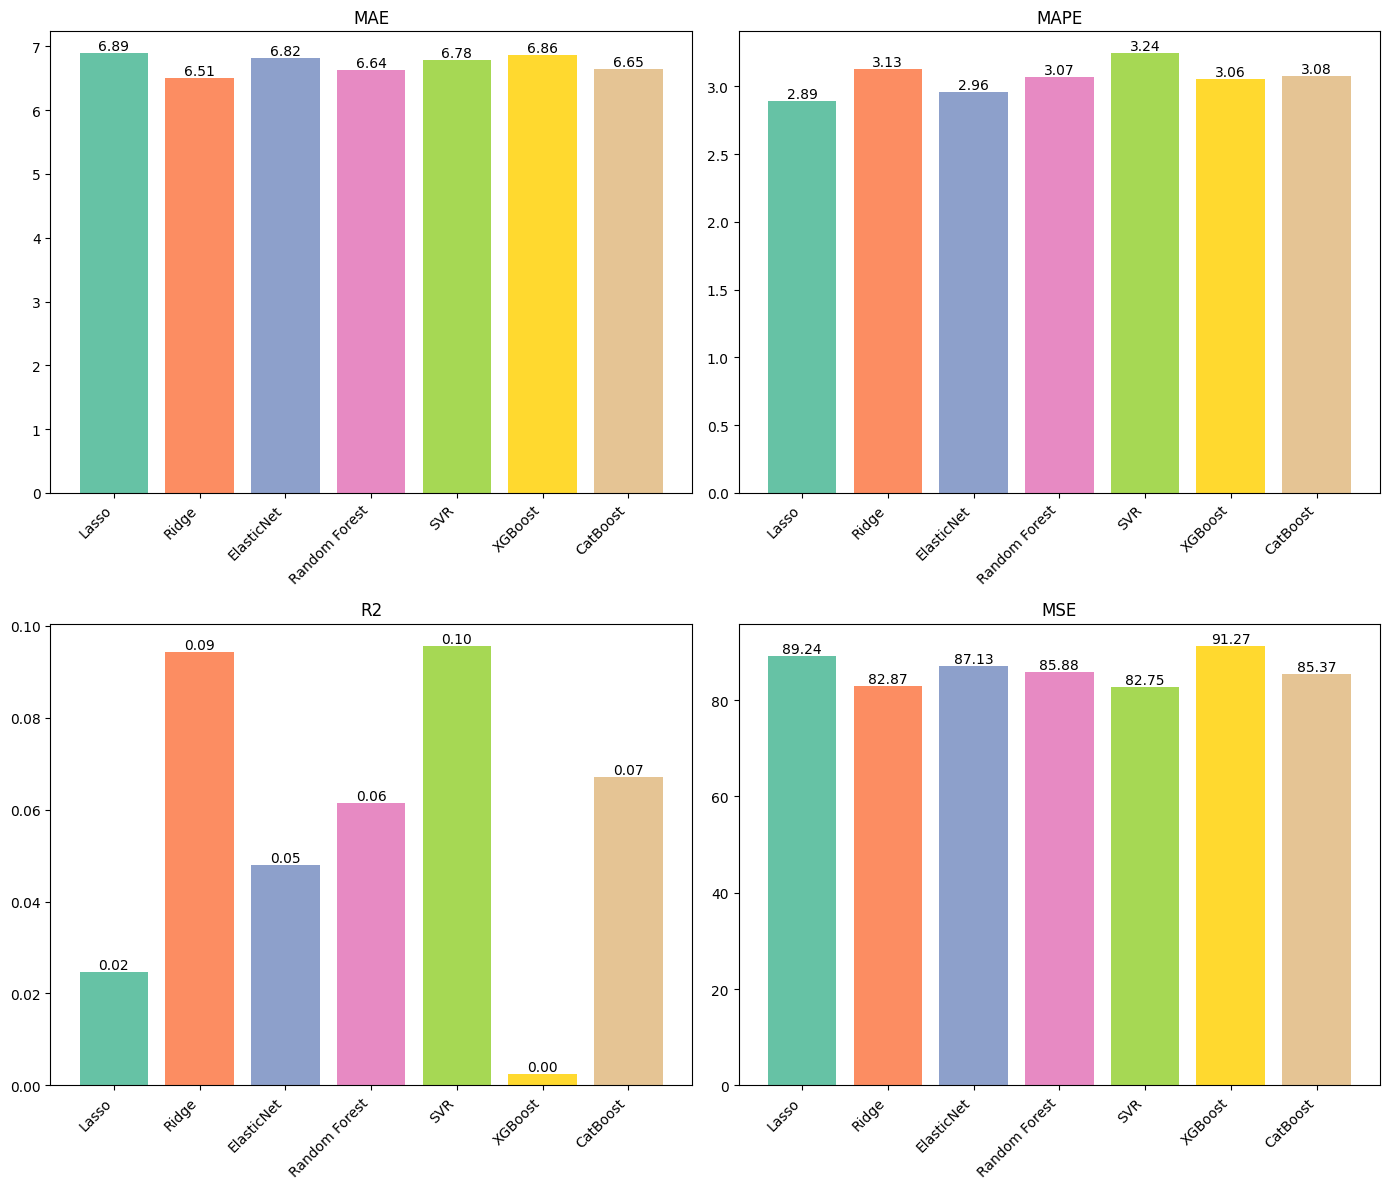

In [33]:
# Построить графики результатов
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
palette = sns.color_palette("Set2", len(results))

for i, metric in enumerate(list(metrics.keys())):
    ax = axes[i // 2, i % 2]
    
    models = list(results.keys())
    values = [results[model][metric] for model in models]
    bars = ax.bar(models, values, color=palette)
    ax.set_title(metric)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Выводы**  
  
1. В рамках настоящей задачи были рассмотрены следующие модели:
- Линейные модели (`Lasso`, `Ridge`, `ElasticNet`);
- `RandomForest`;
- `SVR`;
- `XGBoostRegressor`;
- `CatBoostRegressor`.
  
   Наиболее оптимальными моделями по совокупности использованных метрик принимаются `SVR` и `CatBoost`.
2. Метрики всех моделей оказались недостаточно высокими. В качестве рекомендаций по дальнейшему улучшению предсказательной способности моделей требуется более глубокая обработка исходных данных. Как показал ранее выполненный EDA, в данных присутствует существенное число выбросов, однако для их эффективного устранения требуется знание специфики отрасли и понимание ключевой важности тех или иных признаков, что не было выполнено в настоящей работе.